In [1]:
# section 1 load all the necessary modules and packages
import glob
import time
import geopandas as gpd
import netCDF4 as nc4
import numpy as np
import pandas as pd
import xarray as xr
from shapely.geometry import Polygon
# not neccessary for the function but for visualziation
import matplotlib.pyplot as plt
import warnings
import sys
import os
import platform
import shutil
import networkx as nx
import contextily as ctx
import matplotlib  as mpl
font = {'family' : 'Times New Roman',
            'weight' : 'bold',
            'size'   : 40}
mpl.rc('font', **font)


/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [101]:
#mm/month
#Month     Jan. Feb. Mar. Apr. May June July Aug. Sept. Oct. Nov. Dec. Total
#Radiation 135  127  144  132  123 109  113  126  135   145  132  129  1550
#Penman    150  145  162  146  138 130  135  144  148   154  145  146  1743

#other studies from Yin
other_evap = np.array([1550, 1350, 1130, 1520, 1450, 1500, 1370, 1590, 1470, 1470, 1590, 1590, 1400])

           Evaporation
Date                  
1969-01-15         135
1969-02-15         127
1969-03-15         144
1969-04-15         132
1969-05-15         123
...                ...
2023-08-15         126
2023-09-15         135
2023-10-15         145
2023-11-15         132
2023-12-15         129

[660 rows x 1 columns]


,Evaporation
Date,
1969-01-15,4.500000
1969-01-16,4.491398
1969-01-17,4.482796
1969-01-18,4.474194
1969-01-19,4.465591
...,...
2023-12-11,4.313333
2023-12-12,4.310000
2023-12-13,4.306667


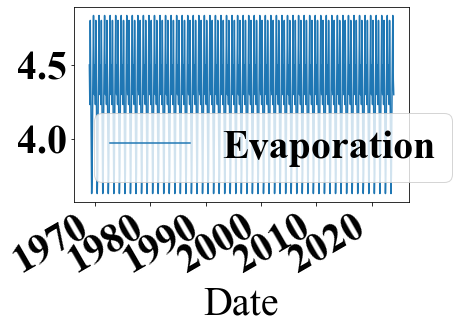

In [102]:
# Define the monthly values
monthly_values = np.array([135, 127, 144, 132, 123, 109, 113, 126, 135, 145, 132, 129])

# Define the range of years
start_year = 1969
end_year = 2023

# Create an empty DataFrame
df = pd.DataFrame(columns=['Date', 'Evaporation'])

# Loop through the years
for year in range(start_year, end_year + 1):
    # Loop through the months
    for month in range(1, 13):
        # Create a date string for the 15th of each month
        date_str = f'{year}-{month:02d}-15'

        # Create a new row with the date and the corresponding monthly value
        row = {'Date': pd.to_datetime(date_str), 'Evaporation': monthly_values[month - 1]}

        # Append the row to the DataFrame
        df = df.append(row, ignore_index=True)

# Print the resulting DataFrame
df['Date'] = pd.to_datetime(df['Date'])
# Set the 'Date' column as the time index
df.set_index('Date', inplace=True)
print(df)

# make it dayly values
df['Evaporation'] = df['Evaporation'].astype(float)/30 # mm per month to mm per day
df.plot()
df_resampled = df.resample('D').interpolate(method='linear')
df_resampled


In [32]:
file_names = sorted(glob.glob('../data/remapped_VIC/VIC_lake_victoria_remapped_*-01-01-00-00-00.nc'))

for file_name in file_names:
    
    import xarray as xr

    # Open the NetCDF file
    dataset = xr.open_dataset(file_name)
    
    # Access the time variable
    time_variable = dataset['time']
    
    year = time_variable.dt.year


    year = np.array(year)
    year = year[0]
    year = year.item()
    print(np.unique(year))
    
    m = 1
    
    for var in other_evap:
        
        df_resampled_year = df_resampled.loc[df_resampled.index.year == year]
        
        print(df_resampled_year)
        
        df_resampled_year['Evaporation'] = df_resampled_year['Evaporation'] * (var/1550)
        
        
        idx = np.array(np.where(ds['ID']==7000016)) # lake victoria
        idx = idx[0]
        print(idx)
        
        dataset ['evapw_'+str(m)] = dataset ['evapw'].copy()
        dataset ['evapw_'+str(m)][:,idx] = df_resampled_year['Evaporation'].values.reshape(len(df_resampled_year),1)
        
        
        print(dataset)
        
        if os.path.isfile(file_name+'_evap_ens'):
            os.remove(file_name+'_evap_ens')
        dataset.to_netcdf(file_name+'_evap_ens',\
                          encoding = {var: {'_FillValue': -9999, 'zlib': True, 'complevel': 9} for var in dataset.data_vars})
        
        m = m +1
    

[1979]


NameError: name 'other_evap' is not defined

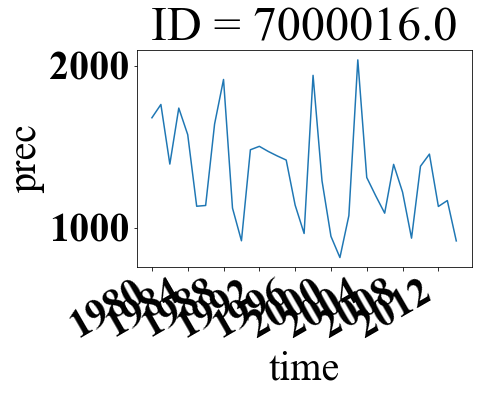

In [50]:
file_names = sorted(glob.glob('../data/remapped_VIC/VIC_lake_victoria_remapped_*-01-01-00-00-00.nc'))

sliced_datasets_all =[]

for file_name in file_names:
    
    import xarray as xr

    # Open the NetCDF file
    dataset = xr.open_dataset(file_name)
    #print(dataset)
    
    
    sliced_dataset = dataset['prec'].isel(ID=512) # 512 # IRFroutedRunoff # IRFvolume

    # Append the sliced dataset to the list
    sliced_datasets_all.append(sliced_dataset)

    # Close the dataset
    dataset.close()

# Merge the sliced datasets into a single dataset
sliced_datasets_all = xr.concat(sliced_datasets_all, dim='time')

#sliced_datasets_all.plot()
sliced_datasets_all

sliced_datasets_all_Y = sliced_datasets_all.resample(time='1Y').sum(dim='time')

sliced_datasets_all_Y.plot()

    

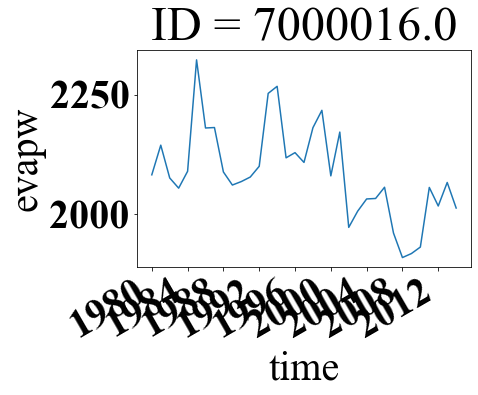

In [51]:
file_names = sorted(glob.glob('../data/remapped_VIC/VIC_lake_victoria_remapped_*-01-01-00-00-00.nc'))

sliced_datasets_all =[]

for file_name in file_names:
    
    import xarray as xr

    # Open the NetCDF file
    dataset = xr.open_dataset(file_name)
    #print(dataset)
    
    
    sliced_dataset = dataset['evapw'].isel(ID=512) # 512 # IRFroutedRunoff # IRFvolume

    # Append the sliced dataset to the list
    sliced_datasets_all.append(sliced_dataset)

    # Close the dataset
    dataset.close()

# Merge the sliced datasets into a single dataset
sliced_datasets_all = xr.concat(sliced_datasets_all, dim='time')

#sliced_datasets_all.plot()
sliced_datasets_all

sliced_datasets_all_Y = sliced_datasets_all.resample(time='1Y').sum(dim='time')

sliced_datasets_all_Y.plot()


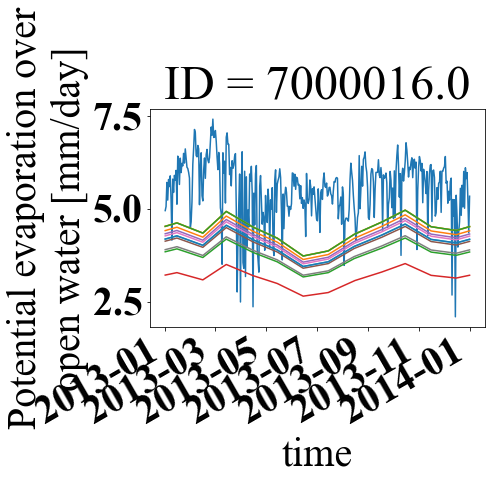

In [104]:
for i in ['','_1','_2','_3','_4','_5','_6','_7','_8','_9','_10','_11','_12']:
    dataset['evapw'+i][:,512].plot()

In [105]:
dataset

<xarray.Dataset>
Dimensions:    (time: 365, ID: 518)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-31
  * ID         (ID) float64 2e+06 2e+06 2e+06 ... 7.016e+06 7.016e+06 7.181e+06
Data variables: (12/18)
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    prec       (time, ID) float32 ...
    evapw      (time, ID) float32 ...
    runoff     (time, ID) float32 ...
    evapw_1    (time, ID) float32 ...
    ...         ...
    evapw_8    (time, ID) float32 ...
    evapw_9    (time, ID) float32 ...
    evapw_10   (time, ID) float32 ...
    evapw_11   (time, ID) float32 ...
    evapw_12   (time, ID) float32 ...
    evapw_13   (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Tue Jul 11 14:35:57 2023
    Source:       Case: VIC_lake_victoria; remapped by script from library of...

In [155]:
ds = xr.open_dataset('/Users/shg096/Downloads/HDMA_hydrolake_Victoria.h.1992-01-01-00000.nc')
ds

<xarray.Dataset>
Dimensions:          (time: 366, hru: 518, seg: 518)
Coordinates:
  * time             (time) datetime64[ns] 1992-01-01 1992-01-02 ... 1992-12-31
Dimensions without coordinates: hru, seg
Data variables:
    basinID          (hru) int32 ...
    reachID          (seg) int32 ...
    basRunoff        (time, hru) float32 ...
    IRFroutedRunoff  (time, seg) float32 ...
    volume           (time, seg) float32 ...

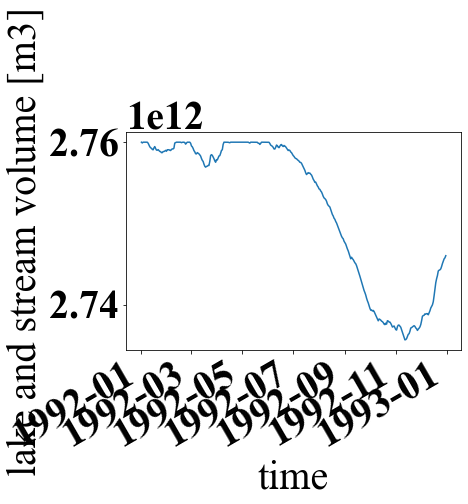

In [156]:
for i in np.arange(1979,2023):
    ds_temp = ds['volume'][:,512].plot()

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


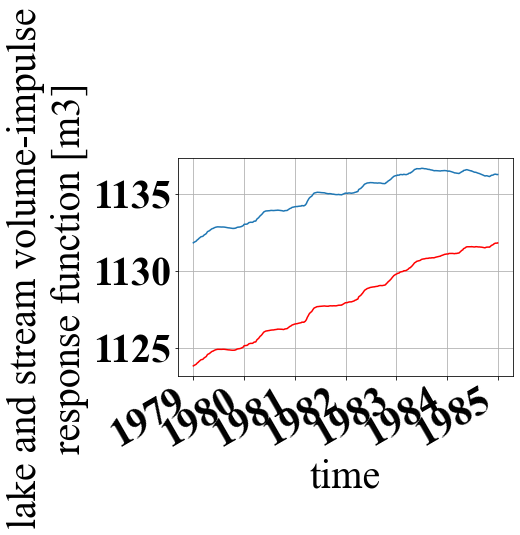

In [24]:
# section 1 load all the necessary modules and packages
import glob
import time
import geopandas as gpd
import netCDF4 as nc4
import numpy as np
import pandas as pd
import xarray as xr
from shapely.geometry import Polygon
# not neccessary for the function but for visualziation
import matplotlib.pyplot as plt
import warnings
import sys
import os
import platform
import shutil
import networkx as nx
import contextily as ctx
import matplotlib  as mpl
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 40}
mpl.rc('font', **font)


sliced_datasets =[]

for file_path in sorted(glob.glob('/Users/shg096/Downloads/HDMA_hydrolake_Victoria_restart.h.*.nc')):

    dataset = xr.open_dataset(file_path)
    #print(dataset)
    #print(dataset['basinID'][:10])

    idx = np.array(np.where(dataset['basinID']==7000016)) # lake victoria 7015942, 7015959, 7180987
    idx = idx[0]
    print(idx)

    # Slice the dataset
    sliced_dataset = dataset['IRFvolume'].isel(seg=1) # 512 # IRFroutedRunoff # IRFvolume

    # Append the sliced dataset to the list
    sliced_datasets.append(sliced_dataset)

    # Close the dataset
    dataset.close()

# Merge the sliced datasets into a single dataset
merged_dataset = xr.concat(sliced_datasets, dim='time')

merged_dataset = merged_dataset.to_dataset()
merged_dataset['elevation'] = merged_dataset['IRFvolume']
merged_dataset['elevation'][:] = merged_dataset['elevation'][:]/(6.716622*10**10)+1122.86
merged_dataset['elevation'].plot()
#plt.ylim([1132,1137])

# print(merged_dataset['elevation'][0])
# merged_dataset.plot()

#merged_dataset['IRFvolume'].plot(c='r')




sliced_datasets =[]

for file_path in sorted(glob.glob('/Users/shg096/Downloads/HDMA_hydrolake_Victoria.h.*.nc')):

    dataset = xr.open_dataset(file_path)
    #print(dataset)
    #print(dataset['basinID'][:10])

    idx = np.array(np.where(dataset['basinID']==7000016)) # lake victoria
    idx = idx[0]
    print(idx)

    # Slice the dataset
    sliced_dataset = dataset['IRFvolume'].isel(seg=1) # 512 # IRFroutedRunoff # IRFvolume

    # Append the sliced dataset to the list
    sliced_datasets.append(sliced_dataset)

    # Close the dataset
    dataset.close()

# Merge the sliced datasets into a single dataset
merged_dataset = xr.concat(sliced_datasets, dim='time')

merged_dataset = merged_dataset.to_dataset()
merged_dataset['elevation'] = merged_dataset['IRFvolume']
merged_dataset['elevation'][:] = merged_dataset['elevation'][:]/(6.716622*10**10)+1122.86
merged_dataset['elevation'].plot(c='r')
#plt.ylim([1132,1137])

# print(merged_dataset['elevation'][0])
# # merged_dataset.plot()

# merged_dataset['IRFvolume'].plot(c='b')

plt.grid()


In [40]:
ds1 = xr.open_dataset('/Users/shg096/Downloads/HDMA_hydrolake_Victoria.h.1981.nc')
ds2 = xr.open_dataset('/Users/shg096/Downloads/HDMA_hydrolake_Victoria_restart.h.1981.nc')


diff = ds1['IRFvolume'][:]-ds2['IRFvolume'][:]

print(ds1)

diff[364,:]


#ds1['IRFvolume'][365,:]

<xarray.Dataset>
Dimensions:          (time: 365, tbound: 2, hru: 518, seg: 518)
Coordinates:
  * time             (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1981-12-31
Dimensions without coordinates: tbound, hru, seg
Data variables:
    time_bounds      (time, tbound) datetime64[ns] ...
    basinID          (hru) int32 ...
    basRunoff        (time, hru) float32 ...
    reachID          (seg) int32 ...
    IRFroutedRunoff  (time, seg) float32 ...
    IRFvolume        (time, seg) float32 ...
Attributes:
    mizuRoute-version:  
    gitBranch:          cesm-coupling_lake_vol_initialization-0-g36478e3
    gitHash:            36478e346301b564d9e92f1f2c18dc7dc9407fa2


<xarray.DataArray 'IRFvolume' (seg: 518)>
array([0.0000000e+00, 7.2256111e+10, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
...
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 8.2871000e+04,
       0.0000000e+00, 2.6069000e+04, 9.6800215e+03, 9.6950400e+03,
       9.5401434e+08, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)
Coordinates:
    time     datetime64[ns] 1981-12-31
Dimensions without coordinates: seg

In [19]:
merged_dataset
merged_dataset = merged_dataset.to_dataset()
merged_dataset

<xarray.Dataset>
Dimensions:    (time: 12784)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2013-12-31
Data variables:
    IRFvolume  (time) float32 6.738e+10 6.787e+10 ... 8.916e+11 8.922e+11

<xarray.Dataset>
Dimensions:          (time: 365, hru: 518, seg: 518)
Coordinates:
  * time             (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
Dimensions without coordinates: hru, seg
Data variables:
    basinID          (hru) int32 ...
    reachID          (seg) int32 ...
    basRunoff        (time, hru) float32 ...
    IRFroutedRunoff  (time, seg) float32 ...
    volume           (time, seg) float32 ...
[512]


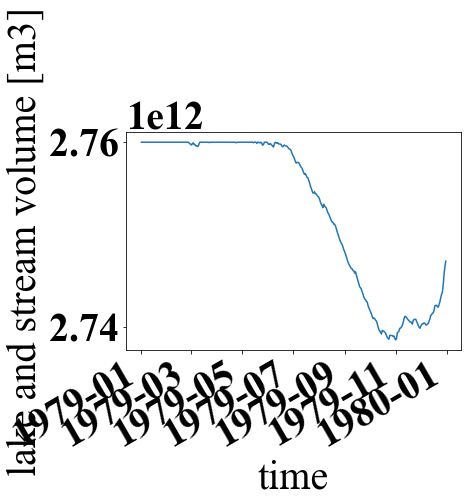

In [50]:
# section 1 load all the necessary modules and packages
import glob
import time
import geopandas as gpd
import netCDF4 as nc4
import numpy as np
import pandas as pd
import xarray as xr
from shapely.geometry import Polygon
# not neccessary for the function but for visualziation
import matplotlib.pyplot as plt
import warnings
import sys
import os
import platform
import shutil
import networkx as nx
import contextily as ctx
import matplotlib  as mpl
font = {'family' : 'Times New Roman',
            'weight' : 'bold',
            'size'   : 40}
mpl.rc('font', **font)


sliced_datasets =[]

for file_path in sorted(glob.glob('/Users/shg096/Downloads/HDMA_hydrolake_Victoria.h.1979-01-01-00000.nc')):

    dataset = xr.open_dataset(file_path)
    print(dataset)
    
    idx = np.array(np.where(dataset['reachID']==7000016)) # lake victoria
    idx = idx[0]
    print(idx)
    

    # Slice the dataset
    sliced_dataset = dataset['volume'].isel(seg=512) # 512

    # Append the sliced dataset to the list
    sliced_datasets.append(sliced_dataset)

    # Close the dataset
    dataset.close()

# Merge the sliced datasets into a single dataset
merged_dataset = xr.concat(sliced_datasets, dim='time')

merged_dataset.plot()

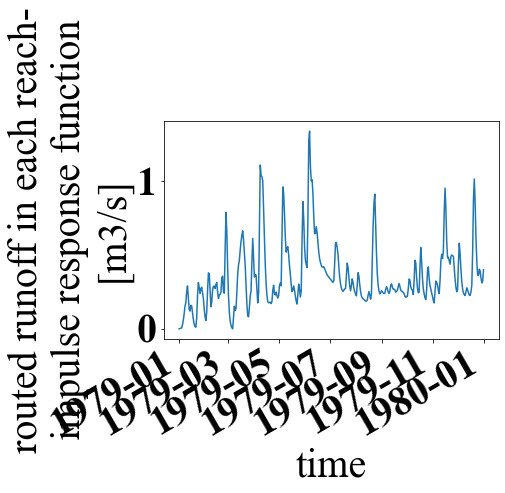

In [11]:
merged_dataset.plot()

In [167]:
idx = np.where(np.isin(dataset['reachID'].values, 2062605))
idx = np.array(idx).flatten()
idx

array([511])

In [195]:
dataset['reachID'].values[-10:]

array([2062556, 2062561, 2062562, 2062605, 7000016, 7001596, 7001598,
       7015942, 7015959, 7180987], dtype=int32)

In [8]:
(6.75*10**11)/(6.716622*10**10)

10.04969462327938

In [58]:
0.0005*(6.716622*10**10)/(24*3600)


388.6934027777778

In [9]:
ds = xr.open_dataset('/Users/shg096/Downloads/HDMA_hydrolake_Victoria.r.1979-01-01-00000.nc')
ds

<xarray.Dataset>
Dimensions:          (seg: 518, tbound: 2, ens: 1, tdh: 9, tdh_irf: 3, hru: 518)
Dimensions without coordinates: seg, tbound, ens, tdh, tdh_irf, hru
Data variables: (12/14)
    nNodes           int32 ...
    nt               int32 ...
    reachID          (seg) int32 ...
    restart_time     datetime64[ns] ...
    history_time     (tbound) datetime64[ns] ...
    time_bound       (tbound) float32 ...
    ...               ...
    numQF            (ens, seg) int32 ...
    irf_qfuture      (ens, tdh_irf, seg) float64 ...
    volume_irf       (ens, tbound, seg) float64 ...
    IRFroutedRunoff  (seg) float64 ...
    IRFvolume        (seg) float64 ...
    basRunoff        (hru) float64 ...

In [11]:
ds['nNodes']=2

ds.to_netcdf('/Users/shg096/Downloads/HDMA_hydrolake_Victoria.r.1979-01-01-00000.nc')
ds

<xarray.Dataset>
Dimensions:          (seg: 518, tbound: 2, ens: 1, tdh: 9, tdh_irf: 3, hru: 518)
Dimensions without coordinates: seg, tbound, ens, tdh, tdh_irf, hru
Data variables: (12/14)
    nNodes           int64 2
    nt               int32 0
    reachID          (seg) int32 2062605 7000016 2047836 ... 2001067 2001938
    restart_time     datetime64[ns] 1985-01-01
    history_time     (tbound) datetime64[ns] 1984-12-31 1985-01-01
    time_bound       (tbound) float32 1.893e+08 1.894e+08
    ...               ...
    numQF            (ens, seg) int32 2 2 2 2 2 2 2 2 2 3 ... 2 2 2 2 2 2 2 2 2
    irf_qfuture      (ens, tdh_irf, seg) float64 30.34 0.0 ... -9.999e+03
    volume_irf       (ens, tbound, seg) float64 2.61e+06 6.012e+11 ... 0.0 0.0
    IRFroutedRunoff  (seg) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    IRFvolume        (seg) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    basRunoff        (hru) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0